#### 참고 코드

- https://github.com/HwangToeMat/SRCNN_Pytorch_HTM


- https://datastore-of-pren-k.tistory.com/7


- https://github.com/yjn870/SRCNN-pytorch

#### 데이터 출처

- https://github.com/HwangToeMat/SRCNN_Pytorch_HTM/tree/master/data

---

## 필요 라이브러리 불러오기

In [1]:
import os
import numpy as np
from scipy import misc
import glob
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage
import cv2
import PIL.Image as pil_image
from PIL import ImageFilter

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

## 경로 설정

In [2]:
path = './train_srcnn/'

# 절대 경로로 현재 위치 주소를 가져옴
dir_path = os.path.join(os.getcwd(), path)

# glob 메소드를 이용해 bmp 파일을 모두 가져옴
image_path = glob.glob(os.path.join(dir_path, '*.bmp'))

## 데이터 전처리

In [3]:
def preprocess(patch_size = 33, stride = 14, scale = 3): # patch 정보
    
    lr_patches, hr_patches = [], []

    for path in image_path:
        # label이 될 고해상도 이미지(hr) 생성
        hr = pil_image.open(path).convert('RGB')
        
        # 저해상도 이미지에 Gaussian Blur 적용시키기 위해 정의
        # 논문에는 Gaussian Blur 적용한다고 되어있어서 한건데, 다른 오픈소스 코드에선 대부분 적용하지 않음...
        # Gaussian Blur를 적용 or 적용X 한 이미지를 비교해볼 것
        hr_gauss = hr.filter(ImageFilter.GaussianBlur(radius = 2))

        hr_width = (hr.width // scale) * scale
        hr_height = (hr.height // scale) * scale
        
        # 고해상도 이미지도 bicubic interpolation 적용
        hr = hr.resize((hr_width, hr_height), resample = pil_image.BICUBIC)
        
        # Gaussian Blur, upscaling, bicubic interpolation 적용해서 input이 될 저해상도 이미지(lr) 생성
        # Gaussian Blur 적용 유무를 아래 코드들 주석 처리 or 주석 처리 X로 결정
        # 1번 코드 주석 처리: Gaussian Blur 적용 X, 2번 코드 주석 처리: Gaussian Blur 적용 O
        
        # lr = hr_gauss.resize((hr_width // scale, hr_height // scale), resample = pil_image.BICUBIC) # 1번
        lr = hr.resize((hr_width // scale, hr_height // scale), resample = pil_image.BICUBIC) # 2번
        
        lr = lr.resize((lr.width * scale, lr.height * scale), resample = pil_image.BICUBIC)

        hr = np.array(hr).astype(np.float32)
        lr = np.array(lr).astype(np.float32)
        
        # 고해상도, 저해상도 이미지에서 stride 간격만큼 이동하면서 패치 추출
        for i in range(0, lr.shape[0] - patch_size + 1, stride):
            for j in range(0, lr.shape[1] - patch_size + 1, stride):

                sub_lr = lr[i:i + patch_size, j:j + patch_size]
                sub_hr = hr[i:i + patch_size, j:j + patch_size]
                
                # 뽑힌 패치를 빈 리스트에 삽입
                lr_patches.append(sub_lr)
                hr_patches.append(sub_hr)
    
    # 패치가 들어간 리스트를 np.array로 변환
    lr_patches = np.array(lr_patches)
    hr_patches = np.array(hr_patches)
    
    return lr_patches, hr_patches

## torch용 데이터셋 만드는 클래스 정의

In [4]:
class SRdataset(Dataset):
    def __init__(self):
        self.lr, self.hr = preprocess()[0]/255., preprocess()[1]/255.
        
    def __len__(self):
        return self.lr.shape[0]
    
    def __getitem__(self, idx):
        lr_sample = self.lr[idx]
        hr_sample = self.hr[idx]
        
        # (가로, 세로, 채널) -> (채널, 가로, 세로) 모양으로 변환
        lr_sample = lr_sample.transpose(2,0,1)
        hr_sample = hr_sample.transpose(2,0,1)
        
        # 들어온 np.array들을 torch Tensor 형태로 변환
        lr_sample, hr_sample = torch.Tensor(lr_sample), torch.Tensor(hr_sample)
        
        return lr_sample, hr_sample

## 모델 정의

In [5]:
# f1 = 9, f2 = 1, f3 = 5, n1 = 64, n2 = 32

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size = 9, stride = 1, padding = 4),
                nn.ReLU())
        
        self.layer2 = nn.Sequential(
                nn.Conv2d(64, 32, kernel_size = 1, stride = 1, padding = 0),
                nn.ReLU())
        
        self.layer3 = nn.Sequential(
                nn.Conv2d(32, 3, kernel_size = 5, stride = 1, padding = 2))
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        return x

In [6]:
from torchsummary import summary

model = SRCNN()
summary(model, (3, 33, 33)) # 크롭된 sub-image 사이즈 = 33x33

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 33, 33]          15,616
              ReLU-2           [-1, 64, 33, 33]               0
            Conv2d-3           [-1, 32, 33, 33]           2,080
              ReLU-4           [-1, 32, 33, 33]               0
            Conv2d-5            [-1, 3, 33, 33]           2,403
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.62
Params size (MB): 0.08
Estimated Total Size (MB): 1.71
----------------------------------------------------------------


## 모델 학습

In [7]:
def PSNR(loss):
    psnr = 10 * np.log10(1 / (loss + 1e-10))
    return psnr

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2, momentum = 0.9)

train_set = SRdataset()
train_loader = DataLoader(train_set, batch_size = 64, shuffle = False)

for epoch in range(400):
    for i in train_loader:
        model.zero_grad()
        x, y = i
        image_data, label_data = Variable(x), Variable(y)
        total_loss = 0
        
        output_data = model(image_data)
        
        loss = criterion(output_data, label_data)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = total_loss/len(train_loader)
    psnr = PSNR(epoch_loss) 
    
    # PSNR이 논문 값보다 더 높게 나왔는데, 이는 여러 부분 논문에서 설정한 하이퍼파라미터와 다른 점이 있기 때문.    
    print("===> Epoch[{}]: loss : {:.9f}, PSNR : {:.3f}".format(epoch+1, epoch_loss, psnr))    

===> Epoch[1]: loss : 0.000010210, PSNR : 49.910
===> Epoch[2]: loss : 0.000006479, PSNR : 51.885
===> Epoch[3]: loss : 0.000004743, PSNR : 53.240
===> Epoch[4]: loss : 0.000004065, PSNR : 53.910
===> Epoch[5]: loss : 0.000003655, PSNR : 54.371
===> Epoch[6]: loss : 0.000003380, PSNR : 54.711
===> Epoch[7]: loss : 0.000003177, PSNR : 54.979
===> Epoch[8]: loss : 0.000003013, PSNR : 55.210
===> Epoch[9]: loss : 0.000002881, PSNR : 55.405
===> Epoch[10]: loss : 0.000002765, PSNR : 55.583
===> Epoch[11]: loss : 0.000002662, PSNR : 55.748
===> Epoch[12]: loss : 0.000002577, PSNR : 55.889
===> Epoch[13]: loss : 0.000002504, PSNR : 56.013
===> Epoch[14]: loss : 0.000002441, PSNR : 56.124
===> Epoch[15]: loss : 0.000002385, PSNR : 56.224
===> Epoch[16]: loss : 0.000002335, PSNR : 56.316
===> Epoch[17]: loss : 0.000002290, PSNR : 56.401
===> Epoch[18]: loss : 0.000002250, PSNR : 56.479
===> Epoch[19]: loss : 0.000002213, PSNR : 56.550
===> Epoch[20]: loss : 0.000002180, PSNR : 56.616
===> Epoc

===> Epoch[164]: loss : 0.000001569, PSNR : 58.044
===> Epoch[165]: loss : 0.000001568, PSNR : 58.046
===> Epoch[166]: loss : 0.000001568, PSNR : 58.047
===> Epoch[167]: loss : 0.000001567, PSNR : 58.049
===> Epoch[168]: loss : 0.000001566, PSNR : 58.051
===> Epoch[169]: loss : 0.000001566, PSNR : 58.053
===> Epoch[170]: loss : 0.000001565, PSNR : 58.055
===> Epoch[171]: loss : 0.000001564, PSNR : 58.057
===> Epoch[172]: loss : 0.000001564, PSNR : 58.059
===> Epoch[173]: loss : 0.000001563, PSNR : 58.060
===> Epoch[174]: loss : 0.000001562, PSNR : 58.062
===> Epoch[175]: loss : 0.000001562, PSNR : 58.064
===> Epoch[176]: loss : 0.000001561, PSNR : 58.066
===> Epoch[177]: loss : 0.000001560, PSNR : 58.067
===> Epoch[178]: loss : 0.000001560, PSNR : 58.069
===> Epoch[179]: loss : 0.000001559, PSNR : 58.071
===> Epoch[180]: loss : 0.000001559, PSNR : 58.073
===> Epoch[181]: loss : 0.000001558, PSNR : 58.074
===> Epoch[182]: loss : 0.000001557, PSNR : 58.076
===> Epoch[183]: loss : 0.00000

===> Epoch[325]: loss : 0.000001510, PSNR : 58.210
===> Epoch[326]: loss : 0.000001510, PSNR : 58.211
===> Epoch[327]: loss : 0.000001509, PSNR : 58.212
===> Epoch[328]: loss : 0.000001509, PSNR : 58.213
===> Epoch[329]: loss : 0.000001509, PSNR : 58.214
===> Epoch[330]: loss : 0.000001508, PSNR : 58.214
===> Epoch[331]: loss : 0.000001508, PSNR : 58.215
===> Epoch[332]: loss : 0.000001508, PSNR : 58.216
===> Epoch[333]: loss : 0.000001508, PSNR : 58.217
===> Epoch[334]: loss : 0.000001507, PSNR : 58.217
===> Epoch[335]: loss : 0.000001507, PSNR : 58.218
===> Epoch[336]: loss : 0.000001507, PSNR : 58.219
===> Epoch[337]: loss : 0.000001507, PSNR : 58.220
===> Epoch[338]: loss : 0.000001506, PSNR : 58.220
===> Epoch[339]: loss : 0.000001506, PSNR : 58.221
===> Epoch[340]: loss : 0.000001506, PSNR : 58.222
===> Epoch[341]: loss : 0.000001506, PSNR : 58.222
===> Epoch[342]: loss : 0.000001505, PSNR : 58.223
===> Epoch[343]: loss : 0.000001505, PSNR : 58.224
===> Epoch[344]: loss : 0.00000

## 임의의 이미지로 테스트

In [11]:
patch_size = 33
stride = 14
scale = 3

hr = pil_image.open('photo.bmp').convert('RGB')
hr_gauss = hr.filter(ImageFilter.GaussianBlur(radius = 2))

hr_width = (hr.width // scale) * scale
hr_height = (hr.height // scale) * scale

hr = hr.resize((hr_width, hr_height), resample=pil_image.BICUBIC)
lr = hr.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)

lr_sample = np.array(lr).astype(np.float32)
lr_sample = lr_sample.reshape(1, lr_sample.shape[0], lr_sample.shape[1], 3) 
lr_sample = lr_sample.transpose(0,3,1,2)

print(lr_sample.shape)

lr_sample = torch.Tensor(lr_sample)
lr_sample = Variable(lr_sample)

test_output = model(lr_sample)

print(test_output.shape)

test_output = test_output.data.numpy()
test_output = test_output[0].transpose(1, 2, 0)
h, w = test_output.shape[0], test_output.shape[1]
test_output = test_output.reshape(h, w, 3)

print(test_output.shape)

(1, 3, 198, 210)
torch.Size([1, 3, 198, 210])
(198, 210, 3)


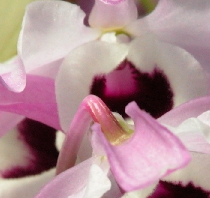

In [9]:
# 0. 고해상도 이미지 (label)

hr

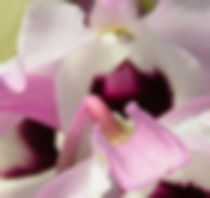

In [10]:
# 1-1. 저해상도 이미지 (input) (Gaussian Blur 적용)

lr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


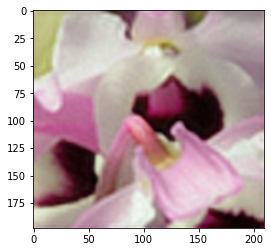

In [11]:
# 1-2. Gaussian Blur 적용한 테스트용 사진이 SRCNN 모델을 통과한 결과

test_output = test_output.astype(np.int)
plt.imshow(test_output)
plt.show()

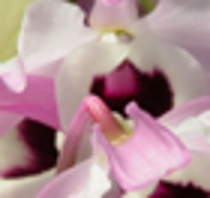

In [12]:
# 2-1. 저해상도 이미지 (input) (Gaussian Blur 적용 X)

lr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


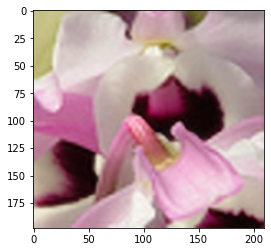

In [13]:
# 2-2. Gaussian Blur 적용 X인 테스트용 사진이 SRCNN 모델을 통과한 결과

test_output = test_output.astype(np.int)
plt.imshow(test_output)
plt.show()

---

## 이미지 전처리 실험

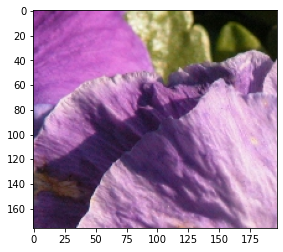

(176, 197, 3)


In [12]:
# 이미지 정보 사진으로 출력하기

image = imageio.imread(image_path[0]).astype(np.int)
plt.imshow(image)
plt.show()
print(image.shape) # height, width, channel - 아래 for문의 한 예시

In [13]:
image

Array([[[140,  49, 142],
        [136,  45, 140],
        [138,  47, 143],
        ...,
        [ 20,  23,   6],
        [ 23,  26,   9],
        [ 27,  30,  13]],

       [[137,  46, 139],
        [132,  43, 137],
        [138,  47, 143],
        ...,
        [ 20,  23,   6],
        [ 18,  21,   4],
        [ 22,  23,   7]],

       [[136,  49, 144],
        [142,  55, 150],
        [140,  50, 148],
        ...,
        [ 19,  23,   8],
        [ 20,  22,   8],
        [ 25,  23,   8]],

       ...,

       [[ 71,  54,  88],
        [ 66,  41,  81],
        [ 71,  44,  87],
        ...,
        [173, 130, 173],
        [187, 144, 187],
        [214, 169, 208]],

       [[ 70,  54,  90],
        [ 63,  42,  83],
        [ 68,  45,  87],
        ...,
        [174, 129, 172],
        [190, 148, 188],
        [217, 172, 211]],

       [[ 72,  61,  95],
        [ 60,  42,  82],
        [ 64,  46,  86],
        ...,
        [182, 136, 182],
        [193, 151, 191],
        [213, 168, 207]]

In [14]:
patch_size = 33
stride = 14
scale = 3

hr = pil_image.open(image_path[0]).convert('RGB')
hr_gauss = hr.filter(ImageFilter.GaussianBlur(radius = 2))

hr_width = (hr.width // scale) * scale
hr_height = (hr.height // scale) * scale

hr = hr.resize((hr_width, hr_height), resample=pil_image.BICUBIC)
lr = hr_gauss.resize((hr_width // scale, hr_height // scale), resample=pil_image.BICUBIC)
lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)

195 174


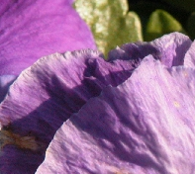

In [15]:
print(hr.width, hr.height)

hr

195 174


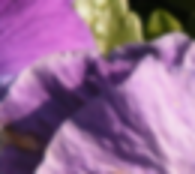

In [16]:
print(lr.width, lr.height)

lr

In [17]:
hr = np.array(hr).astype(np.float32)
lr = np.array(lr).astype(np.float32)

In [18]:
hr

array([[[140.,  49., 142.],
        [136.,  45., 140.],
        [138.,  47., 143.],
        ...,
        [ 20.,  23.,   6.],
        [ 23.,  26.,   9.],
        [ 27.,  30.,  13.]],

       [[137.,  46., 139.],
        [132.,  43., 137.],
        [138.,  47., 143.],
        ...,
        [ 20.,  23.,   6.],
        [ 18.,  21.,   4.],
        [ 22.,  23.,   7.]],

       [[136.,  49., 144.],
        [142.,  55., 150.],
        [140.,  50., 148.],
        ...,
        [ 19.,  23.,   8.],
        [ 20.,  22.,   8.],
        [ 25.,  23.,   8.]],

       ...,

       [[ 71.,  54.,  88.],
        [ 66.,  41.,  81.],
        [ 71.,  44.,  87.],
        ...,
        [173., 130., 173.],
        [187., 144., 187.],
        [214., 169., 208.]],

       [[ 70.,  54.,  90.],
        [ 63.,  42.,  83.],
        [ 68.,  45.,  87.],
        ...,
        [174., 129., 172.],
        [190., 148., 188.],
        [217., 172., 211.]],

       [[ 72.,  61.,  95.],
        [ 60.,  42.,  82.],
        [ 64.,  

In [19]:
print(hr.shape)
print(lr.shape)

(174, 195, 3)
(174, 195, 3)


In [20]:
i, j = 0, 0
patch_size = 33
lr_patches, hr_patches = [], []

sub_lr = lr[i:i + patch_size, j:j + patch_size]
sub_hr = hr[i:i + patch_size, j:j + patch_size]

lr_patches.append(sub_lr)
hr_patches.append(sub_hr)

lr_patches = np.array(lr_patches)
hr_patches = np.array(hr_patches)

In [21]:
print(lr_patches.shape)
print(hr_patches.shape)

(1, 33, 33, 3)
(1, 33, 33, 3)
